In [2]:
from __future__ import  division
import os,sys
import pandas as pd
import numpy as np
import jieba
import re

#启动绘图
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




/home/zuozuo/workspace/word_alignment/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zuozuo/workspace/word_alignment/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


2.挖掘目标
对文本中的comma数据集进行挖掘建模，目标如下：
1.分析fast-align 的词对齐质量
2.从提炼出来的数据集中发现重要特征与不足
3.提炼出比较重要的特征集

3.分析过程 （review）
对8个专利数据集的MT数据集进行英文分词，建立词向量表达，主题模型等多种文本挖掘模型，实现对文本评论数据的情感倾向性判断以及文本信息挖掘，以期望得到有价值的内容


In [ ]:
4.分析过程
4.1数据采集
机器翻译中的MT数据集，来自于patsnap官网上的8个领域内的专利内容，经过丁杨，超超前辈处理得到的数据集abst_en,abst_cn（cn为源语言，en为目标语言），数据样例如下：

In [3]:
with open('abst_cn')as cn, open('abst_en')as en:
    i =0
    while(i<2):
        chinese = cn.readline()
        print(chinese)
        english = en.readline()
        print(english)
        i +=1


本实用新型属于家用电器领域，具体涉及一种高强电热锅，包括锅体，其特征在于锅体上压有压痕。本实用新型所具有的有益效果是：结构简单，制作方便，大大增加了锅体的抗冲击能力，使得锅体坚固耐用，延长了使用寿命。

The utility model belongs to the field of household appliances, in particular to a high-strength electric heating pan. The high-strength electric heating pan comprises a pan body, and is characterized in that press marks are arranged on the pan body. The high-strength electric heating pan has the benefits of simple structure and convenience in use; and the shock resistant capability of the pan body is greatly increased, so that the pan body is firm and durable, and the service life is prolonged.

一种带扣装置用滑动开关，组装于带扣装置，其具备：基体(20)；滑块(30)，其可滑动移动地保持于该基体(20)，通过带扣装置侧的可动部按压而滑动移动；固定触点(41～43)，其沿滑动移动方向配置在基体(20)的与滑块(30)相对的面上；可动接片(44)，其安装于滑块(30)上，伴随滑块(30)的滑动移动，在基体(20)的固定触点配置面上滑动。滑块(30)在其滑动移动的全范围为可覆盖固定触点(41～43)的大小。固定触点(41～43)不易受异物等的影响，并能够防止附着损害性能那样的异物。

A slide switch installed in a buckle apparatus includes a body 20, a slider 30 held slidably in the body 20, the slider 30 sliding when pressed by a 

3379015 abst_cn


4.2数据预处理
我们做的任务是检测机器翻译的质量优劣，所以做了中文分词（jieba_fast），英文分词(spacy2.0)，使用fast_align进行了词对齐，最后在词对齐文本中，寻找对应上comma-comma，comma-period,comma-semicolon
一共发现了587632条数据，提取了comma前5个token，后5个token，形成我们的训练数据集，样例如下：

In [4]:
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns',1000)
outputfile = 'data/comma_id.txt'
data = pd.read_csv('comma_train',sep='\t\s',names = ['data']) #设置一个不存在的词
data.to_csv(outputfile,index = False , header = False)
print(data.head(5))
print(data.tail(5))
print(len(data))

                                                                data
0         the field of household appliances, in particular to a high
1                  body is firm and durable, and the service life is
2                         solvates thereof , wherein R1, R2 , R4 , A
3  - frequency plasma CVD method, an inductive coupling discharge is
4                  fitness device contains a strap, a handle , and a
                                                                       data
587627  including earthworm , dipsacus root, clematis root , tetrandra root
587628               dipsacus root , clematis root, tetrandra root , etc ..
587629            clematis root , tetrandra root, etc .. Its advantages are
587630   advantages are unique curative effect, short course of treatment (
587631                                   5 - 30 days ), and no recurrence .
587632


In [5]:
import spacy
import os
# 英文语料分词
save_path = 'data/'
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner', 'parser'])
dirnames =  'comma_train'  # 要读的目录
comma_cut = os.path.join(save_path, 'comma_process1')  # 要写的目录

with open(dirnames) as  fr, open(comma_cut, 'w') as en:
    for line in fr:
        if line.strip():
            doc = nlp(line)
            tokens = [w.text for w in doc]
            en.write(' '.join(tokens))
data = pd.read_csv(comma_cut,sep='\t\s',names = ['data'])
data.to_csv('data/comma_cut',index = False , header = False)

In [6]:
print('使用英文分词（spcay）后结果\n',data.head(5))
print(data.tail(5))
print(len(data))

使用英文分词（spcay）后结果
                                                                  data
0         the field of household appliances , in particular to a high
1                  body is firm and durable , and the service life is
2                         solvates thereof , wherein R1 , R2 , R4 , A
3  - frequency plasma CVD method , an inductive coupling discharge is
4                  fitness device contains a strap , a handle , and a
                                                                        data
587627  including earthworm , dipsacus root , clematis root , tetrandra root
587628               dipsacus root , clematis root , tetrandra root , etc ..
587629            clematis root , tetrandra root , etc .. Its advantages are
587630   advantages are unique curative effect , short course of treatment (
587631                                   5 - 30 days ) , and no recurrence .
587632


4.3 LDA主题模型
LDA是一种主题模型（Topic Model），LDA于2003年由David Blei，Andrew Ng 和 Michael I.Jordan 提出。
LDA认为同一个词，在不同的主题背景下，它出现的概率是不同的。文章和主题之间并不一定是一一对应的，也就是说，
文章可以有多个主题，一个主题可以在多篇文章之中。同一个主题，在不同的文章中，他出现的比例（概率）是不同的。
每个主题会对应一个词汇分布，而每个文档会对应一个主体分布。
因此，LDA定义两个分布：主题与词汇的分布，文章与主题的分布，即每个主题会对应一个词汇分布，每个文档会对应一个主题分布。
主题K通过词汇的概率分布来反映。主题和词汇的分布就是多项式分布，而文章和主体之间的分布也是符合多项式分布。假设语料库
中有词库V = {v1，v2，v3，...vn}，现在有k个主题，有M篇文章。在主题模型中，主题表现为一系列相关的单词的条件概率。
K1 ： {v1:0.01，v3:0.2，v4：0.3，v6:0.1...}

K2 ： {v1:0.11，v3:0.22，v4：0.34，v6:0.61...}

而每份文档也是一系列主题的概率分布：

M1：{K1:0.1，K2:0.3，K3:0.5}

M2：{K1:0.5，K2:0.3，K3:0.1}

我们将原始数据中正确对应的comma-comma分为pos，comma-semicolon，comma-period分为neg，分别对正类和负类提取主题。
经过提取，pos类581483条数据集，neg类6149条数据集

In [22]:
import time
start = time.time()
with open('data/comma_process1')as tr,open('comma_pos','w')as pos,open('comma_neg','w')as neg:
    for line in tr:
        if len(line.split()) == 11 :
            for count,item in enumerate(line.split()):  #有一个逻辑是，如果逗号前面不足5个token，或者后面不足5个token，
                                                       #那么只取最大数目的token，所以不可以用5来衡量，所以要分情况讨论
                if count == 5:
                    if item == ',':
                        pos.write(' '.join(line.split()))
                        pos.write('\n')
                        break
                    elif item == ';' or item == '.':
                        neg.write(' '.join(line.split()))
                        neg.write('\n')
                        break
        elif len(line.split())!=11 :
            for count,item in enumerate(line.split()):
                if item == ',':
                    pos.write(' '.join(line.split()))
                    pos.write('\n')
                    break
                elif item == ';' or item == '.':
                    neg.write(' '.join(line.split()))
                    neg.write('\n')
                    break
data1 = pd.read_csv('comma_pos',sep='\t\s',names = ['data']) #读入数据
data2 = pd.read_csv('comma_neg',sep='\t\s',names = ['data'])

#data1 = pd.DataFrame(data1[0].str.replace('.*?\d+?\\t','')) #用正则表达式修改数据
#data2 = pd.DataFrame(data2[0].str.replace('.*?\d+?\\t',''))

data1.to_csv('data/comma_pos',index = False,header = False) #保存结果
data2.to_csv('data/comma_neg',index = False,header = False)

l1 = len(data1)
l2 = len(data2)
end = time.time()
print('过程耗时%4.2f 秒' %(end -start))
print('正面样例有 %s 条'%l1)
print('负面样例有 %s 条'%l2)

过程耗时4.15 秒
正面样例有 581483 条
负面样例有 6149 条


In [25]:
start = time.time()

inputfile1 = 'data/comma_pos'
inputfile2 = 'data/comma_neg'
outputfile1 = 'data/comma_pos_1'
outputfile2 = 'data/comma_neg_1'

data_pos = pd.read_csv('comma_pos',sep='\t\s') #读入数据
data_pos['label'] = 1
data_pos.columns = ['words','label']

data_neg = pd.read_csv('comma_neg',sep='\t\s')
data_neg['label'] = 0
data_neg.columns = ['words','label']
print(data_pos.head())
print(data_neg.tail())

                                                                words  label
0                  body is firm and durable , and the service life is      1
1                         solvates thereof , wherein R1 , R2 , R4 , A      1
2  - frequency plasma CVD method , an inductive coupling discharge is      1
3                  fitness device contains a strap , a handle , and a      1
4                             broom wires ( 2 ) , as well as a screen      1
                                                                                         words  \
6143                    - butanol as raw material ; regarding nonpolar hydrocarbon compound as   
6144  nonpolar hydrocarbon compound as solvent ; selecting fitful reacting material proportion   
6145                                    fly ash or bottom ash ; an additive composition , with   
6146                         comparing a finger - print ; and measuring content of ingredients   
6147                              with a triangu

In [28]:
data_combine = pd.concat([data_neg,data_pos],axis = 0)#将正样本与负样本拼接在一起

import string
desl = string.punctuation
desl = desl + "、（）"
data_combine['words_punc'] = data_combine['words'].apply(lambda s: re.sub(r'[%s]+'%desl,"",s))
data_combine['words_cuts'] = data_combine['words_punc'].apply(lambda s:[w.text for w in nlp(s.strip())])

In [32]:
data_combine.head()

,words,label,words_punc,words_cuts
0,"checking the software expanding packet ; if passing the check ,",0,checking the software expanding packet if passing the check,"[checking, the, software, expanding, packet, , if, passing, the, check]"
1,effect and no environmental pollution .,0,effect and no environmental pollution,"[effect, and, no, environmental, pollution]"
2,material continually with adjacent connecting ; adapting feeding at back to,0,material continually with adjacent connecting adapting feeding at back to,"[material, continually, with, adjacent, connecting, , adapting, feeding, at, back, to]"
3,"metronidazole , miconazole and erythromycin . Its preparing process is also",0,metronidazole miconazole and erythromycin Its preparing process is also,"[metronidazole, , miconazole, and, erythromycin, , Its, preparing, process, is, also]"
4,"officinalis , sealwort and liquorice ; the traditional Chinese medicine can",0,officinalis sealwort and liquorice the traditional Chinese medicine can,"[officinalis, , sealwort, and, liquorice, , the, traditional, Chinese, medicine, can]"


3.数据探索 
了解数据的分布

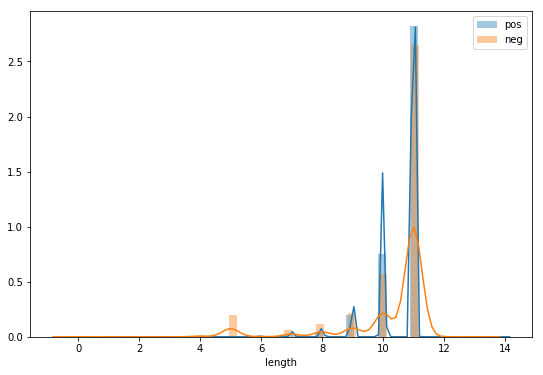

In [41]:
import seaborn as sns
data_combine['length'] = data_combine['words_cuts'].apply(lambda s:len(s))
plt.figure(figsize=(9,6))
sns.distplot(data_combine[data_combine['label'] == 1]['length'],label = 'pos')
sns.distplot(data_combine[data_combine['label'] == 0]['length'],label = 'neg')
plt.legend(['pos','neg'])

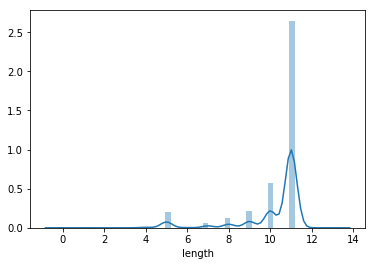

In [42]:
sns.distplot(data_combine[data_combine['label'] == 0]['length'],label = 'neg')
#plt.legend(['pos','neg'])

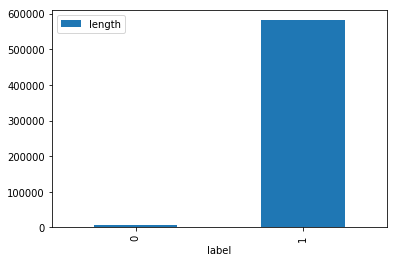

In [53]:
#正负向语料比例情况

data_combine.pivot_table(index = 'label',aggfunc={'length':'count'}).plot(kind = 'bar')


(-0.5, 1239.5, 879.5, -0.5)

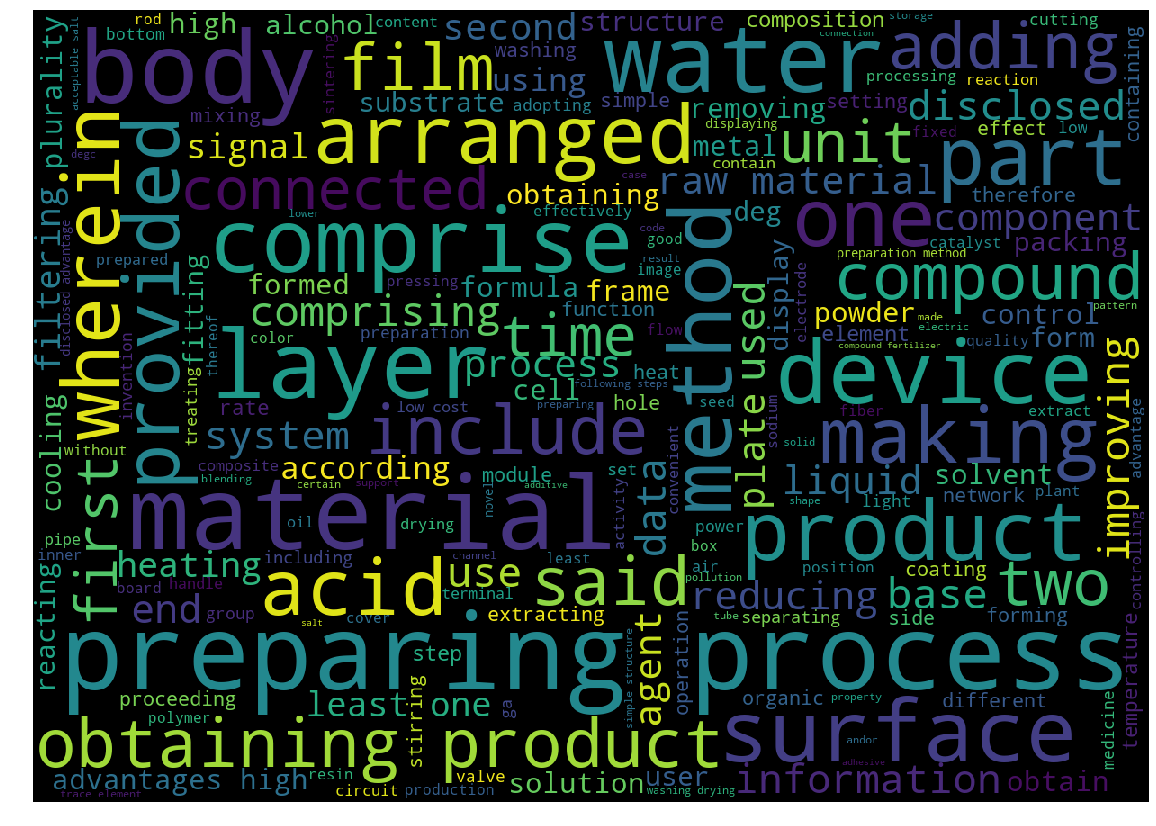

In [78]:
#文本可视化 --制作词云
from wordcloud import WordCloud
#data_combine.drop(['lenth'],axis=1,inplace=True)
data_combine.head(5)
data_combine['space_words'] = data_combine['words_cuts'].apply(lambda s: ' '.join(s))
cloud = WordCloud(width = 1240, height = 880).generate((' '.join(data_combine[data_combine['label']== 0 ]['space_words'])))
plt.figure(figsize = (20,15))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1239.5, 879.5, -0.5)

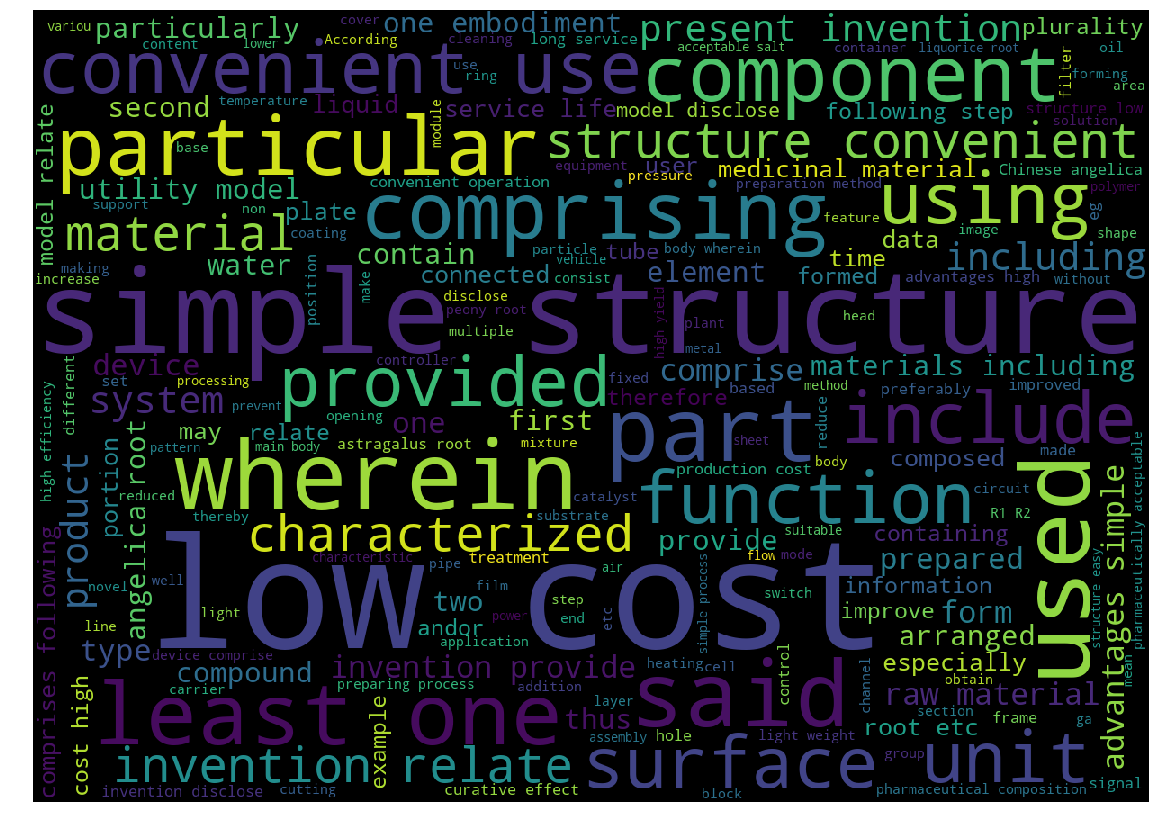

In [79]:
cloud = WordCloud(width = 1240, height = 880).generate((' '.join(data_combine[data_combine['label']== 1 ]['space_words'])))
plt.figure(figsize = (20,15))
plt.imshow(cloud)
plt.axis('off')

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

#抽取特征
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_combine['space_words'])
Y = np.array(list(data_combine['label']),dtype = np.int32)



ImportError: cannot import name 'train_test_split'

In [85]:
#划分数据集
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = .2)

In [86]:
print(X_train.shape)
print(Y_train.shape)
print(Y_train)

(470104, 77583)
(470104,)
[1 1 1 ... 1 1 1]


In [87]:
from sklearn.svm import LinearSVC
clf = LinearSVC()

clf.fit(X_train,Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [89]:
#测试模型
from sklearn.metrics import accuracy_score
prediction = clf.predict(X_test)
accuracy_score(prediction,Y_test)

0.9902830012082433

In [4]:
with open('abst_cn')as ar:
    for index, line in enumerate(ar):
        
        print(index,'\t',line)
        if index==3:
            break

0 	 本实用新型属于家用电器领域，具体涉及一种高强电热锅，包括锅体，其特征在于锅体上压有压痕。本实用新型所具有的有益效果是：结构简单，制作方便，大大增加了锅体的抗冲击能力，使得锅体坚固耐用，延长了使用寿命。

1 	 一种带扣装置用滑动开关，组装于带扣装置，其具备：基体(20)；滑块(30)，其可滑动移动地保持于该基体(20)，通过带扣装置侧的可动部按压而滑动移动；固定触点(41～43)，其沿滑动移动方向配置在基体(20)的与滑块(30)相对的面上；可动接片(44)，其安装于滑块(30)上，伴随滑块(30)的滑动移动，在基体(20)的固定触点配置面上滑动。滑块(30)在其滑动移动的全范围为可覆盖固定触点(41～43)的大小。固定触点(41～43)不易受异物等的影响，并能够防止附着损害性能那样的异物。

2 	 一种可重复、具有应急强制解锁功能的形位锁紧机构，可作为磁悬浮飞轮或磁悬浮控制力矩陀螺转子的保护装置。主要由锁紧驱动器、锁柱、支架、微动开关、强制驱动器组成。锁紧驱动器和强制驱动器都由磁铁座、永磁体、电工纯铁环、吸力盘、线圈和活动柱组成。锁柱两端分别为锁紧工作面和传动工作面，通过将活动柱的上下移动转化成锁柱绕转轴的旋转从而实现转子的锁紧或解锁。通过微动开关触点与锁柱的离合判断转转子锁紧状态。锁紧驱动器失效时，强制驱动器推动锁紧驱动器活动柱移动实现应急强制解锁。本发明的锁紧装置保护了磁悬浮飞轮或磁悬浮控制力矩陀螺系统，具有可重复使用、可靠性高、结构简单等优点。

3 	 一种用于控制线性压缩机活塞位置的装置和方法，该压缩机具有一个电源、一个三端双向开关和一个电机，所述装置包括：一个电流相位检测部分，用以检测在三端双向开关转换的电流、积分电流、生成与积分电流相对应的第一方形波；一个行程相位检测部分，用以根据随电机运转的活塞往复位置生成一个具有固定的频率和变化的振幅的AC电压波形，并生成与所述AC电压波形相对应的第二方形波；一个零交叉检测部分，用以检测电源所供电压的零交叉；以及一个控制部分，用以根据电流相位检测部分所测的第一方形波与行程相位检测部分所测的第二方形波之间的相位差生成一个信号，来控制活塞位置，这样，通过控制汽缸中活塞的位置，根据电流方形波与行程方形波的相位差使得顶部间隙变得最小，从而使效率和可靠性达到最佳。



64400